# Population Density of Mexican States and Municipalities

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe were created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican Municipalities

Read boundary polygons for Mexican states from shapefile

In [3]:
admin2_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin2.parquet'

In [4]:
resp = urlopen(admin2_url)
admin2 = gpd.read_parquet(BytesIO(resp.read()))

Calculate the area of each state (convert area from m^2 to km^2

In [5]:
admin2.crs

<Projected CRS: PROJCRS["MEXICO_ITRF_2008_LCC",BASEGEOGCRS["MEXICO ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
admin2['area_sqkm'] = admin2['geometry'].area/ 10**6

In [7]:
admin2['CVE_MUNI'] = admin2['CVE_ENT'] + admin2['CVE_MUN']

In [8]:
admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,CVE_MUNI
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,01001
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,01002
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,01003
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,01004
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,01005


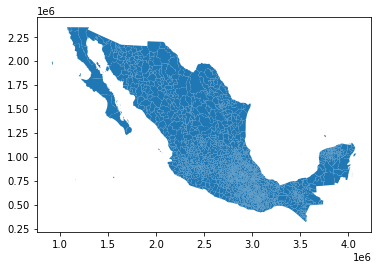

In [9]:
admin2.plot();

## Map of Population by Municipality

Get population from COVID-19 data files

In [10]:
population_admin2 = pd.read_csv('../data/Casos_Diarios_Municipio_Defunciones_20210627.csv', 
                                usecols=['cve_ent', 'poblacion', 'nombre'])

In [11]:
population_admin2.head()

,cve_ent,poblacion,nombre
0,16046,15290,Juarez
1,16047,22358,Jungapeo
2,16048,5862,Lagunillas
3,16049,18769,Madero
4,5035,744247,Torreon


Add 5-digit municipality code column (example: convert 5035 -> 05035)

In [12]:
population_admin2['CVE_MUNI'] = population_admin2['cve_ent'].apply(lambda i: f'{i:05d}')

In [13]:
population_admin2.head()

,cve_ent,poblacion,nombre,CVE_MUNI
0,16046,15290,Juarez,16046
1,16047,22358,Jungapeo,16047
2,16048,5862,Lagunillas,16048
3,16049,18769,Madero,16049
4,5035,744247,Torreon,05035


Merge the geo dataframe with the population dataframe using the common CVE_MUNI column

In [14]:
df_admin2 = admin2.merge(population_admin2, on='CVE_MUNI')

In [15]:
df_admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,CVE_MUNI,cve_ent,poblacion,nombre
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,01001,1001,961977,Aguascalientes
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,01002,1002,50864,Asientos
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,01003,1003,60760,Calvillo
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,01004,1004,16918,Cosio
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,01005,1005,130184,Jesus Maria


Calculate population density

In [16]:
df_admin2['population_density'] = df_admin2['poblacion'] / df_admin2['area_sqkm']

In [17]:
a2 = df_admin2[['population_density']]

In [18]:
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
X = pd.DataFrame(std_scaler.fit_transform(a2))

X.head(10)

,0
0,0.408617
1,-0.176284
2,-0.198527
3,-0.145750
4,-0.042839
5,-0.046689
6,-0.126581
7,-0.242157
8,-0.171948
9,-0.216335


In [19]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
with np.printoptions(threshold=np.inf):
     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1 -1  0  1  2  3  0  0  4  0  0  0  3  2  4  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [20]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [21]:
df_labels.head()

,cluster
0,0
1,0
2,0
3,0
4,0


In [22]:
df2 = pd.concat([df_admin2, df_labels], axis=1)

In [23]:
df2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,CVE_MUNI,cve_ent,poblacion,nombre,population_density,cluster
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,01001,1001,961977,Aguascalientes,824.769043,0
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,01002,1002,50864,Asientos,93.607672,0
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,01003,1003,60760,Calvillo,65.803308,0
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,01004,1004,16918,Cosio,131.777013,0
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,01005,1005,130184,Jesus Maria,260.422641,0


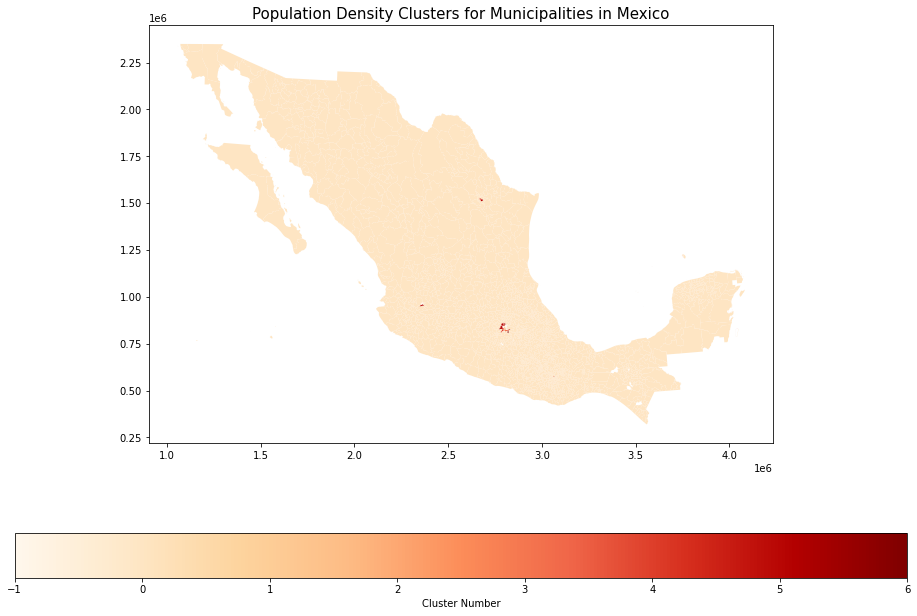

In [24]:
title = 'Population Density Clusters for Municipalities in Mexico'
ax1 = df2.plot(column='cluster', 
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

Plot population data